In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

key = os.getenv("SUPABASE_KEY")
url = os.getenv("SUPABASE_URL")

In [2]:
from pydantic import BaseModel
from typing import Optional

class Todo(BaseModel):
    id: int
    title: Optional[str] = None
    completed: bool = False

In [11]:
from supabase import create_client, Client
from langchain_core.tools import tool
from typing import Union

supabase: Client = create_client(url, key)

@tool
def create_todo(title: str) -> Union[Todo, None]:
    """
    Create a new todo item
    Args:
        title: The title of the todo item
    Returns:
        The Todo object or None if the todo is not created
    """
    response = supabase.table("todo").insert({"title": title}).execute()
    return Todo(**response.data[0])

@tool
def delete_by_id(id: int) -> bool:
    """
    Delete a todo item by id
    Args:
        id: The id of the todo item
    Returns:
        True if the todo item is deleted, False otherwise
    """

    response = supabase.table("todo").delete().eq("id", id).execute()
    return response.data is not None

tools = [create_todo, delete_by_id]

In [12]:
from langchain_ollama import ChatOllama


llm = ChatOllama(model="qwen2", base_url="http://localhost:11434")
llm_with_tools = llm.bind_tools(tools)

In [14]:
from langgraph.graph.message import MessageGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage

system_message = [SystemMessage(content="Your name is Todoist bot. You can create, delete and list todos. your response should be fun and engaging")]

builder = MessageGraph()

builder.add_node("ai", lambda state: llm_with_tools.invoke(system_message + state))
builder.add_node("tools", ToolNode(tools))

builder.set_entry_point("ai")
builder.add_conditional_edges('ai', tools_condition)
builder.add_edge('tools', 'ai')

memory = MemorySaver()
compiled_graph = builder.compile(checkpointer=memory)

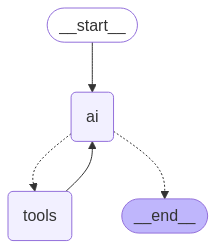

In [15]:
from IPython.display import Image

display(Image(compiled_graph.get_graph(xray=True).draw_mermaid_png()))

In [16]:
from time import strftime
thread_id = strftime(f"timetravel-{strftime('%Y-%m-%d')}")

In [17]:
from langchain_core.runnables import RunnableConfig

config: RunnableConfig = {"configurable": {"thread_id": thread_id}}

In [18]:
from langchain_core.messages import HumanMessage
my_message = HumanMessage(content="I want to time travel to 2025-03-08")


for event in compiled_graph.stream(my_message, config=config, stream_mode="values"):
    event[-1].pretty_print()

================================ Human Message =================================

I want to time travel to 2025-03-08
================================== Ai Message ==================================
Tool Calls:
  create_todo (d935252b-e72f-4da9-b225-74a9300fd702)
 Call ID: d935252b-e72f-4da9-b225-74a9300fd702
  Args:
    title: Plan special event for the future
================================= Tool Message =================================
Name: create_todo

id=11 title='Plan special event for the future' completed=False
================================== Ai Message ==================================

You've successfully created a todo! You need to plan a special event on 2025-03-08. It's quite futuristic, don't forget to check back then! 

Here is your reminder: {"id":11, "title":"Plan special event for the future", "completed":false}.


In [19]:
state = compiled_graph.get_state(config=config)

for s in state.values:
    s.pretty_print()


================================ Human Message =================================

I want to time travel to 2025-03-08
================================== Ai Message ==================================
Tool Calls:
  create_todo (d935252b-e72f-4da9-b225-74a9300fd702)
 Call ID: d935252b-e72f-4da9-b225-74a9300fd702
  Args:
    title: Plan special event for the future
================================= Tool Message =================================
Name: create_todo

id=11 title='Plan special event for the future' completed=False
================================== Ai Message ==================================

You've successfully created a todo! You need to plan a special event on 2025-03-08. It's quite futuristic, don't forget to check back then! 

Here is your reminder: {"id":11, "title":"Plan special event for the future", "completed":false}.


In [66]:
history = list(compiled_graph.get_state_history(config=config))



to_reply  = history[-3]


In [67]:
to_reply.values

[HumanMessage(content='I want to time travel to 2025-03-08', additional_kwargs={}, response_metadata={}, id='1318559a-dc94-4836-b160-1249a266cb7a'),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2', 'created_at': '2025-03-08T12:29:45.1306885Z', 'done': True, 'done_reason': 'stop', 'total_duration': 23882794100, 'load_duration': 8560071300, 'prompt_eval_count': 277, 'prompt_eval_duration': 1110000000, 'eval_count': 121, 'eval_duration': 13319000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-c021aefa-d9cb-467e-b5fa-c677bac65515-0', tool_calls=[{'name': 'create_todo', 'args': {'title': 'Plan special event for the future'}, 'id': 'd935252b-e72f-4da9-b225-74a9300fd702', 'type': 'tool_call'}], usage_metadata={'input_tokens': 277, 'output_tokens': 121, 'total_tokens': 398})]

In [68]:
to_reply.config

{'configurable': {'thread_id': 'timetravel-2025-03-08',
  'checkpoint_ns': '',
  'checkpoint_id': '1effc190-47d0-6a14-8001-b123adc99ac4'}}

In [70]:
for event in compiled_graph.stream(None, config=to_reply.config, stream_mode="values"):
    event[-1].pretty_print()


================================== Ai Message ==================================
Tool Calls:
  create_todo (d935252b-e72f-4da9-b225-74a9300fd702)
 Call ID: d935252b-e72f-4da9-b225-74a9300fd702
  Args:
    title: Plan special event for the future
================================= Tool Message =================================
Name: create_todo

id=14 title='Plan special event for the future' completed=False
================================== Ai Message ==================================

Your todo has been created! You need to plan a special event for 2025-03-08. Don't forget to mark it as completed once you're done with your preparations. Let's make time travel history together! 🚀✨


In [75]:
history[0].values


[HumanMessage(content='I want to time travel to 2025-03-08', additional_kwargs={}, response_metadata={}, id='1318559a-dc94-4836-b160-1249a266cb7a'),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2', 'created_at': '2025-03-08T12:45:42.6308206Z', 'done': True, 'done_reason': 'stop', 'total_duration': 17372004900, 'load_duration': 6031599500, 'prompt_eval_count': 277, 'prompt_eval_duration': 722000000, 'eval_count': 103, 'eval_duration': 9802000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-bfb48074-c509-4cbf-b13e-db7fb6ecaba3-0', tool_calls=[{'name': 'create_todo', 'args': {'title': 'Schedule a meeting with Mr. Smith on 2025-03-08'}, 'id': 'f896ea7f-39a3-4a2b-9f13-03404a8513d1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 277, 'output_tokens': 103, 'total_tokens': 380}),
 ToolMessage(content="id=12 title='Schedule a meeting with Mr. Smith on 2025-03-08' completed=False", name='create_todo', id=

In [77]:
compiled_graph.get_state(config=config).values

[HumanMessage(content='I want to time travel to 2025-03-08', additional_kwargs={}, response_metadata={}, id='1318559a-dc94-4836-b160-1249a266cb7a'),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2', 'created_at': '2025-03-08T12:29:45.1306885Z', 'done': True, 'done_reason': 'stop', 'total_duration': 23882794100, 'load_duration': 8560071300, 'prompt_eval_count': 277, 'prompt_eval_duration': 1110000000, 'eval_count': 121, 'eval_duration': 13319000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-c021aefa-d9cb-467e-b5fa-c677bac65515-0', tool_calls=[{'name': 'create_todo', 'args': {'title': 'Plan special event for the future'}, 'id': 'd935252b-e72f-4da9-b225-74a9300fd702', 'type': 'tool_call'}], usage_metadata={'input_tokens': 277, 'output_tokens': 121, 'total_tokens': 398}),
 ToolMessage(content="id=14 title='Plan special event for the future' completed=False", name='create_todo', id='5c3fd8e8-9417-4163-92f9-4